## Portfolio simulation

In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class2 import PortfolioSimulation2
import matplotlib.pyplot as plt

In [52]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})

In [53]:
# LLM recommendations
llm_recommendations1 = pd.read_csv("../data/ciks1_ratings.csv", dtype={"cik": str})
llm_recommendations1.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)
llm_recommendations2 = pd.read_csv("../data/ciks2_ratings.csv", dtype={"CIK": str})
llm_recommendations2.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations3 = pd.read_csv("../data/ciks3_ratings.csv", dtype={"CIK": str})
llm_recommendations3.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations4 = pd.read_csv("../data/ciks4_ratings.csv", dtype={"CIK": str})
llm_recommendations4.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations5 = pd.read_csv("../data/ciks5_ratings.csv", dtype={"CIK": str})
llm_recommendations5.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations6 = pd.read_csv("../data/ciks6_ratings.csv", dtype={"CIK": str})
llm_recommendations6.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  

# Concat all llm recommendations into one DataFrame
llm_recommendations = pd.concat([
    llm_recommendations1, llm_recommendations2, llm_recommendations3,
    llm_recommendations4, llm_recommendations5, llm_recommendations6
], ignore_index=True)

In [54]:
import re

def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

---

In [55]:
# Read in LLM recommendations with previous quarters
llm_recommendations_w_prev_quarters1 = pd.read_csv("../data/ciklist1_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters2 = pd.read_csv("../data/ciklist2_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters3 = pd.read_csv("../data/ciklist3_ratings_with_previous_quarters.csv", dtype={"cik": str})

llm_recommendations_w_prev_quarters = pd.concat([llm_recommendations_w_prev_quarters1, llm_recommendations_w_prev_quarters2, llm_recommendations_w_prev_quarters3])

---

- Subsetting CIK date combinations that are present in LLM recommendations as well as sell-side analyst ratings

In [56]:
 # Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
llm_recommendations_w_prev_quarters["action"] = llm_recommendations_w_prev_quarters["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)
llm_recommendations_w_prev_quarters["date"] = pd.to_datetime(llm_recommendations_w_prev_quarters["date"]).dt.to_period("M").astype(str)
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)
llm_recommendations_w_prev_quarters.drop_duplicates(subset=["cik", "date"], inplace=True)

In [57]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
llm_prev_quarters_ciks_and_dates = llm_recommendations_w_prev_quarters[["cik", "date"]].drop_duplicates()

# Merge to find common CIK and date combinations
all_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")
all_ciks_and_dates = pd.merge(all_ciks_and_dates, llm_prev_quarters_ciks_and_dates, on=["cik", "date"], how="inner")

# Second set of CIK and dates that contains all dates in revised LLM recs + Analyst recommendations
analyst_and_llm_previous_quarters_ciks_and_dates = pd.merge(analyst_ciks_and_dates, llm_prev_quarters_ciks_and_dates, on=["cik", "date"], how="inner")

In [58]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_w_prev_quarters_final = pd.merge(
    llm_recommendations_w_prev_quarters, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)
llm_recommendations_w_prev_quarters_final["date"] = llm_recommendations_w_prev_quarters_final["date"].astype(str)
len(llm_recommendations_final), len(analyst_ratings_final), len(llm_recommendations_w_prev_quarters_final)

(28493, 28493, 28493)

In [59]:
len(all_ciks_and_dates), len(llm_recommendations_final), len(analyst_ratings_final), len(llm_recommendations_w_prev_quarters_final)

(28493, 28493, 28493, 28493)

In [60]:
llm_recommendations_w_prev_quarters_final["action"].value_counts()

action
hold    14073
sell     7347
buy      7073
Name: count, dtype: int64

In [61]:
llm_recommendations_final["action"].value_counts()

action
hold          13012
sell          12548
buy            2924
strong buy        9
Name: count, dtype: int64

In [62]:
analyst_ratings_final["rating"].value_counts()

rating
buy            18301
hold            8394
strong buy      1508
sell             227
strong sell       63
Name: count, dtype: int64

---
### Selected stock test simulation 

In [63]:
ciks = llm_recommendations_final["cik"].unique()[:1]
ciks

array(['0001996862'], dtype=object)

In [64]:
# Subset 1 CIK for testing
#cik = "0001996862"
cik_prices = stock_prices[stock_prices["cik"].isin([ciks][0])]
cik_llm_recommendations = llm_recommendations_final[llm_recommendations_final["cik"].isin([ciks][0])]
cik_analyst_recommendations = analyst_ratings_final[analyst_ratings_final["cik"].isin([ciks][0])]

In [65]:
start_capital = 1000000
transaction_cost_rate = 0.001
cik_sim = PortfolioSimulation2(initial_capital = start_capital, transaction_cost_rate=transaction_cost_rate)
cik_sim.load_stock_prices(cik_prices)
cik_sim.load_recommendations(cik_llm_recommendations)

# Run simulation
cik_sim.simulate_trading()

Simulating Trades: 100%|██████████| 90/90 [00:00<00:00, 560.73it/s]


In [66]:
cik_sim.portfolio_statistics()

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 979.09it/s] 


{'Mean return (monthly)': np.float64(0.001377),
 'Geometric mean return (monthly)': np.float64(0.001283),
 'Standard deviation (monthly)': np.float64(0.014427),
 'Annualized mean return': np.float64(0.016645),
 'Annualized standard deviation': np.float64(0.049975),
 'Number of buys': 3,
 'Number of sells': 2,
 'Total number of transactions': 5,
 'Number of skipped buys': 0,
 'Number of skipped sells': 68,
 'Total number of skipped transactions': 68,
 'Total amount of transaction costs': np.float64(6650.81319)}

In [67]:
cik_returns = cik_sim.calculate_monthly_returns()
cik_returns

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 1007.32it/s]


,month,start_value,end_value,return,normalized_start_value,normalized_end_value
0,2001-10,1000000.0,1000000.0,0.0,1.000000,1.000000
1,2001-11,1000000.0,1000000.0,0.0,1.000000,1.000000
2,2001-12,1000000.0,1000000.0,0.0,1.000000,1.000000
3,2002-01,1000000.0,1000000.0,0.0,1.000000,1.000000
4,2002-02,1000000.0,1000000.0,0.0,1.000000,1.000000
...,...,...,...,...,...,...
262,2023-08,1408115.5,1408115.5,0.0,1.408116,1.408116
263,2023-09,1408115.5,1408115.5,0.0,1.408116,1.408116
264,2023-10,1408115.5,1408115.5,0.0,1.408116,1.408116
265,2023-11,1408115.5,1408115.5,0.0,1.408116,1.408116


In [68]:
cik_sim_positions = cik_sim.get_positions_over_time()
cik_sim_positions = cik_sim_positions.sort_values(by="date")
cik_sim_positions

Getting Positions Over Time: 100%|██████████| 268/268 [00:00<00:00, 2231.07it/s]


,date,cik,quantity,total_value
0,2001-09,cash,1000000,1000000.00
1,2001-10,cash,1000000,1000000.00
2,2001-11,cash,1000000,1000000.00
3,2001-12,cash,1000000,1000000.00
4,2002-01,cash,1000000,1000000.00
...,...,...,...,...
270,2023-09,cash,1408115,1408115.50
271,2023-10,cash,1408115,1408115.50
272,2023-11,cash,1408115,1408115.50
273,2023-12,cash,6626,6626.65


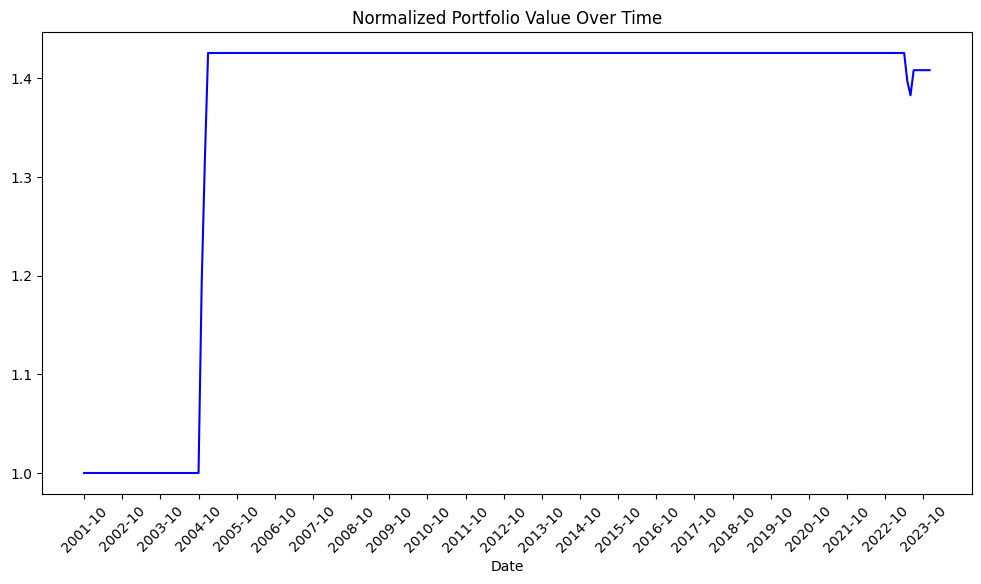

In [69]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = cik_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, cik_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

### LLM recommendations 1 simulation

In [70]:
# Initialize portfolio simulation
llm_sim = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)

# Load data
llm_sim.load_stock_prices(stock_prices)
llm_sim.load_recommendations(llm_recommendations_final)

# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 306/306 [03:56<00:00,  1.29it/s]


In [71]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [09:21<00:00,  1.83s/it]


In [72]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.016754),
 'Geometric mean return (monthly)': np.float64(0.014675),
 'Standard deviation (monthly)': np.float64(0.06673),
 'Annualized mean return': np.float64(0.220654),
 'Annualized standard deviation': np.float64(0.231159),
 'Number of buys': 2697,
 'Number of sells': 1155,
 'Total number of transactions': 3852,
 'Number of skipped buys': 204,
 'Number of skipped sells': 11136,
 'Total number of skipped transactions': 11340,
 'Total amount of transaction costs': np.float64(346740.623998)}

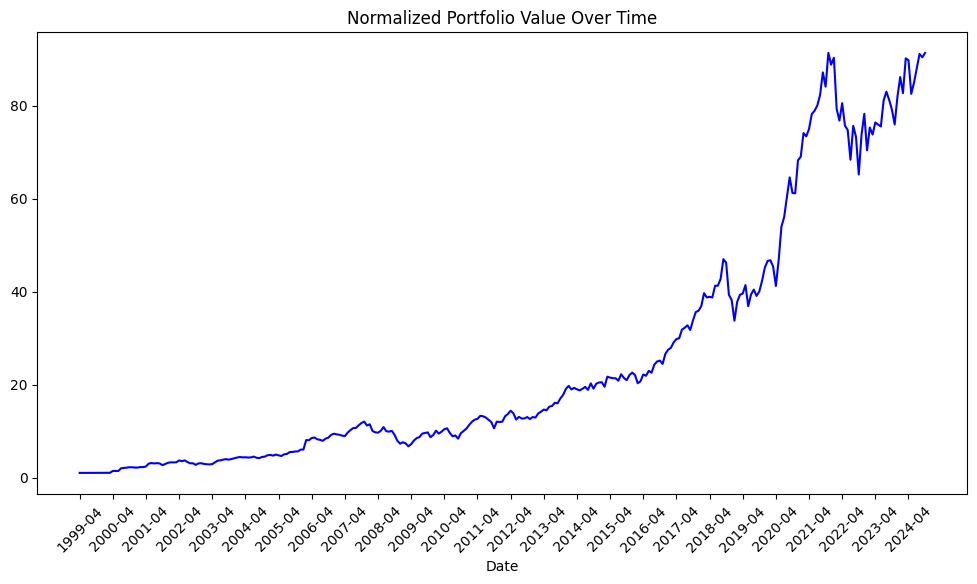

In [73]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = llm_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, llm_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

### LLM recommendations with previous quarters

In [74]:
# Initialize portfolio simulation
llm_sim2 = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)

# Load data
llm_sim2.load_stock_prices(stock_prices)
llm_sim2.load_recommendations(llm_recommendations_w_prev_quarters_final)

# Run simulation
llm_sim2.simulate_trading()

Simulating Trades: 100%|██████████| 306/306 [03:31<00:00,  1.44it/s]


In [75]:
llm_returns2 = llm_sim2.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [20:54<00:00,  4.09s/it]


In [76]:
llm_sim2.portfolio_statistics(monthly_returns =  llm_returns2)

{'Mean return (monthly)': np.float64(0.008623),
 'Geometric mean return (monthly)': np.float64(0.007809),
 'Standard deviation (monthly)': np.float64(0.04082),
 'Annualized mean return': np.float64(0.108532),
 'Annualized standard deviation': np.float64(0.141405),
 'Number of buys': 6659,
 'Number of sells': 1693,
 'Total number of transactions': 8352,
 'Number of skipped buys': 351,
 'Number of skipped sells': 5436,
 'Total number of skipped transactions': 5787,
 'Total amount of transaction costs': np.float64(24286.688643)}

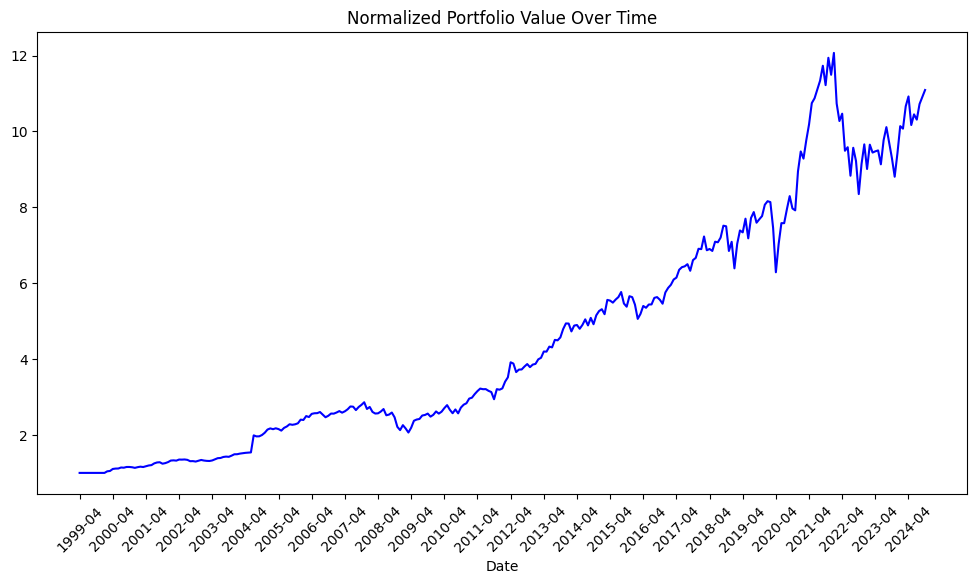

In [77]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = llm_returns2["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, llm_returns2['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---
### Analyst recommendations simulation

In [78]:
analyst_sim = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)
analyst_sim.load_stock_prices(stock_prices)
analyst_sim.load_recommendations(analyst_ratings_final)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 306/306 [04:40<00:00,  1.09it/s]


In [79]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [35:47<00:00,  7.00s/it]


In [80]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.009212),
 'Geometric mean return (monthly)': np.float64(0.008032),
 'Standard deviation (monthly)': np.float64(0.048251),
 'Annualized mean return': np.float64(0.11632),
 'Annualized standard deviation': np.float64(0.167147),
 'Number of buys': 5924,
 'Number of sells': 52,
 'Total number of transactions': 5976,
 'Number of skipped buys': 12165,
 'Number of skipped sells': 238,
 'Total number of skipped transactions': 12403,
 'Total amount of transaction costs': np.float64(1938.975544)}

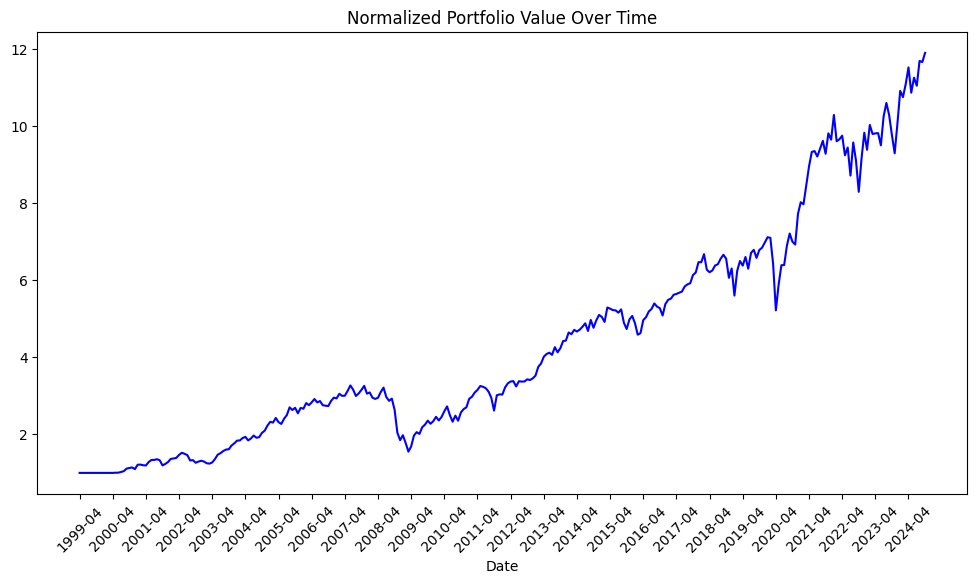

In [81]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = analyst_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, analyst_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

#### Analysis of  PF composition over time 

In [82]:
def plot_pf_shares_over_time(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str)  # Ensure date is string for consistency
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.set_index("date", inplace=True)

    plt.figure(figsize=(9, 6))
    plt.plot(dates, pf_shares["cash_share"], label="Cash Share", color="blue")
    plt.plot(dates, pf_shares["stocks_share"], label="Stocks Share", color="orange")

    plt.xticks(dates[::12], rotation=45)


    plt.title("Portfolio Composition Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Share")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [83]:
plot_pf_shares_over_time(analyst_positions), plot_pf_shares_over_time(llm_positions)

NameError: name 'analyst_positions' is not defined

In [ ]:
def plot_pf_shares_over_time2(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str) 
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.sort_values("date", inplace=True)
    pf_shares.set_index("date", inplace=True)

    # Stacked area plot
    plt.figure(figsize=(9, 6))
    plt.stackplot(
        dates,
        pf_shares["cash_share"],
        pf_shares["stocks_share"],
        labels=["Cash", "Stocks"],
        colors=["skyblue", "orange"]
    )

    plt.xticks(dates[::12], rotation=45)
    plt.title("Portfolio Composition Over Time")
    plt.ylabel("Portfolio Share")
    plt.ylim(0, 1)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


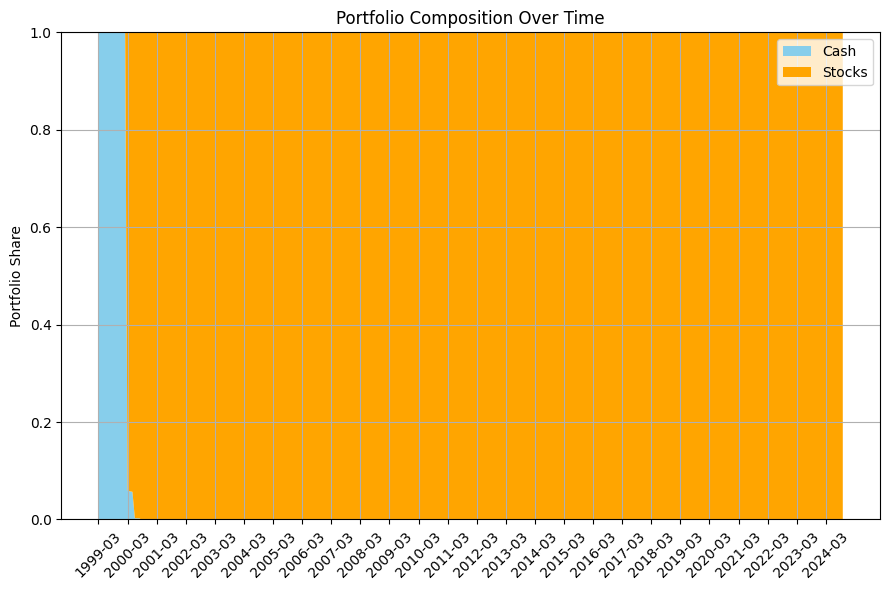

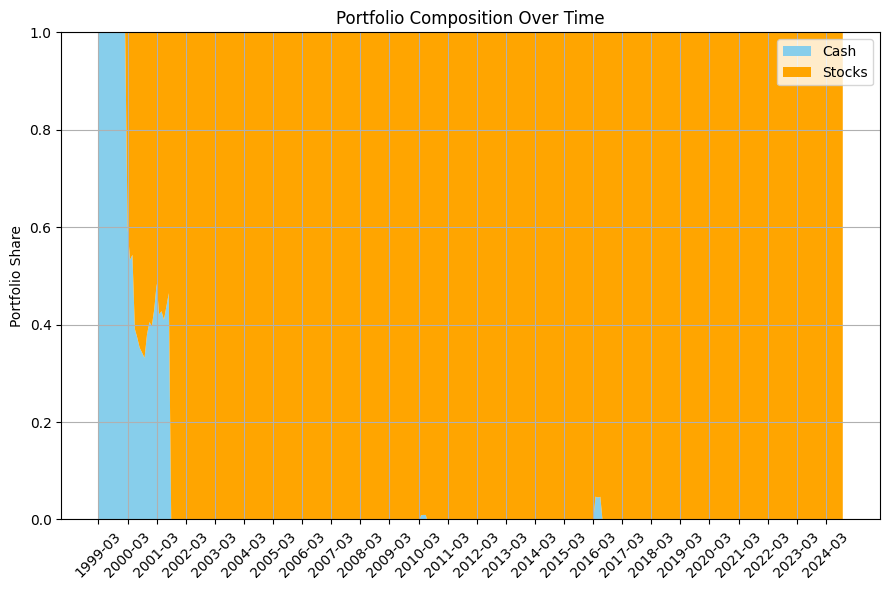

(None, None)

In [ ]:
plot_pf_shares_over_time2(analyst_positions), plot_pf_shares_over_time2(llm_positions)

---

## Large simulation comparing all revised LLM recommendations against all analyst recommendations

In [84]:
# Only keep CIK and date combinations that are in analyst, as well as revised LLM recs
large_analyst_ratings_final = pd.merge(
    analyst_ratings, analyst_and_llm_previous_quarters_ciks_and_dates, on=["cik", "date"], how="inner"
)

large_llm_recommendations_with_previous_quarters_final = pd.merge(
    llm_recommendations_w_prev_quarters, analyst_and_llm_previous_quarters_ciks_and_dates, on=["cik", "date"], how="inner"
)
# Convert date to str
large_analyst_ratings_final["date"] = large_analyst_ratings_final["date"].astype(str)
large_llm_recommendations_with_previous_quarters_final["date"] = large_llm_recommendations_with_previous_quarters_final["date"].astype(str)

len(large_llm_recommendations_with_previous_quarters_final), len(large_analyst_ratings_final)

(78800, 78800)

In [85]:
# Perform an outer merge and filter to get rows in 'llm_recommendations_w_prev_quarters' but not in the final DataFrame
omitted_recs = llm_recommendations_w_prev_quarters.merge(
    large_llm_recommendations_with_previous_quarters_final,
    indicator=True,
    how='left'
).query('_merge == "left_only"').drop('_merge', axis=1)

omitted_recs

,cik,date,rating,action
0,0001576018,2013-03,buy,buy
1,0001576018,2013-06,hold,hold
44,0001748824,2014-03,sell,sell
45,0001748824,2014-06,sell,sell
46,0001748824,2014-09,sell,sell
...,...,...,...,...
82638,0000031462,1999-06,buy,buy
82639,0000031462,1999-09,hold,hold
82737,0000794367,1999-05,hold,hold
82738,0000794367,1999-07,buy,buy


In [86]:
start_capital = 1000000
transaction_cost_rate = 0.001
llm_sim_final = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)
llm_sim_final.load_stock_prices(stock_prices)
llm_sim_final.load_recommendations(large_llm_recommendations_with_previous_quarters_final)
llm_sim_final.simulate_trading()

Simulating Trades: 100%|██████████| 308/308 [09:29<00:00,  1.85s/it]


In [87]:
llm_returns_final = llm_sim_final.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 308/308 [1:08:42<00:00, 13.38s/it]


In [88]:
llm_sim_final_statistics = llm_sim_final.portfolio_statistics(monthly_returns = llm_returns_final)

In [89]:
llm_sim_final_statistics

{'Mean return (monthly)': np.float64(0.008997),
 'Geometric mean return (monthly)': np.float64(0.008309),
 'Standard deviation (monthly)': np.float64(0.037142),
 'Annualized mean return': np.float64(0.113473),
 'Annualized standard deviation': np.float64(0.128664),
 'Number of buys': 18990,
 'Number of sells': 4825,
 'Total number of transactions': 23815,
 'Number of skipped buys': 456,
 'Number of skipped sells': 14089,
 'Total number of skipped transactions': 14545,
 'Total amount of transaction costs': np.float64(24442.690321)}

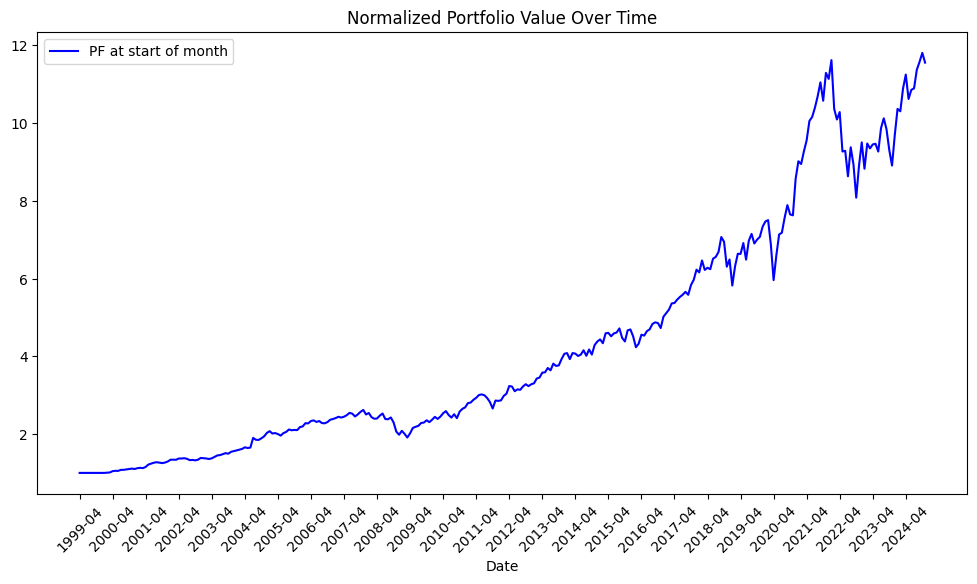

In [90]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = llm_returns_final["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, llm_returns_final['normalized_start_value'], label='PF at start of month', color='blue')
plt.legend()
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

In [91]:
analyst_sim_final = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)
analyst_sim_final.load_stock_prices(stock_prices)
analyst_sim_final.load_recommendations(large_analyst_ratings_final)
analyst_sim_final.simulate_trading()

Simulating Trades: 100%|██████████| 308/308 [19:29<00:00,  3.80s/it]


In [92]:
analyst_returns_final = analyst_sim_final.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 308/308 [1:34:22<00:00, 18.39s/it]


In [93]:
analyst_sim_final_statistics = analyst_sim_final.portfolio_statistics(monthly_returns = analyst_returns_final)

In [94]:
analyst_sim_final_statistics

{'Mean return (monthly)': np.float64(0.012653),
 'Geometric mean return (monthly)': np.float64(0.01148),
 'Standard deviation (monthly)': np.float64(0.048527),
 'Annualized mean return': np.float64(0.162867),
 'Annualized standard deviation': np.float64(0.168103),
 'Number of buys': 4397,
 'Number of sells': 58,
 'Total number of transactions': 4455,
 'Number of skipped buys': 44711,
 'Number of skipped sells': 581,
 'Total number of skipped transactions': 45292,
 'Total amount of transaction costs': np.float64(7204.590528)}

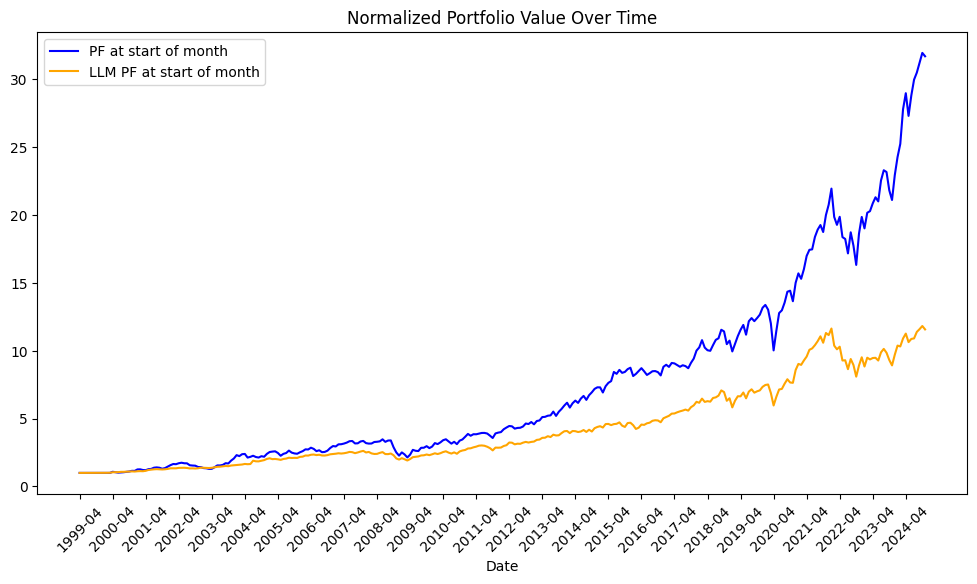

In [97]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = analyst_returns_final["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, analyst_returns_final['normalized_start_value'], label='PF at start of month', color='blue')
plt.plot(dates, llm_returns_final['normalized_start_value'], label='LLM PF at start of month', color='orange')
plt.legend()
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()